# 11 - 倾向得分

## 成长心理学

积极心理学这一领域研究哪些人类行为能引导我们过上更好的人生。你可以把它理解为“自助书籍”和“统计学严谨性”的交叉点。积极心理学中一个著名的发现是“成长型心态”。这个概念认为，人们可以拥有固定型心态或成长型心态。
- 如果你拥有固定型心态，你会认为能力是在出生或早期童年就被决定的。因此，智力是固定的，终生无法改变。如果你现在没有某项能力，那你将永远无法获得它。这种想法的推论是：你不应该在自己不擅长的领域浪费时间，因为你永远也学不会。
- 而如果你拥有成长型心态，你会相信智力是可以被培养的。其直接的结果是：你不会将失败视为缺乏毅力，而是将其视为学习过程中的一部分。

我并不想争论这两种心态中哪一种才是正确的（尽管答案或许介于两者之间）。就我们的目的而言，这并不重要。真正重要的是，心理学家发现拥有成长型心态的人往往在生活中表现更佳。他们更有可能实现自己设定的目标。

尽管我们精通因果推断，但已学会以怀疑态度看待这些论断。究竟是成长型心态促使人们取得更多成就？还是仅仅因为取得更多成就的人容易因其成功而发展出成长型心态？孰因孰果，如同鸡与蛋的悖论？用潜在结果模型表述，我们有理由相信这些陈述存在偏误。$Y_0|T=1$ 很可能大于 $Y_0|T=0$，这意味着即使持有固定型心态，那些具备成长型心态的人原本也能取得更高成就。

为解决这一问题，研究人员设计了“[全国学习心态研究](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#)”。这是一项在美国公立高中开展的随机对照试验，旨在探究成长型心态的影响效果。其运作方式为：学校向学生提供旨在培养成长型心态的研讨会，随后追踪学生大学期间的学业表现以评估成效。这些测量结果被整合成标准化成就分数。出于保护学生隐私的考虑，该研究的真实数据未公开。但我们将使用 [Athey 和 Wager](https://arxiv.org/pdf/1902.07409.pdf) 提供的具有相同统计特性的模拟数据集作为替代。

In [79]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

除处理变量与结果变量外，该研究还记录了以下特征：

* schoolid：学生所在学校的标识符；
* success_expect：自我报告的未来成功预期（作为学业基础能力的代理变量，在随机分配前测得）；
* ethnicity：学生种族/族群的分类变量；
* gender：学生自我认同性别的分类变量；
* frst_in_family：学生是否为家庭第一代大学生的分类变量，即家庭中首个上大学者；
* school_urbanicity：学校层面的城乡属性分类变量，如农村、郊区等；
* school_mindset：随机分配前报告的学生固定型思维模式的校级平均值，标准化处理；
* school_achievement：基于前四届学生测试成绩及大学预备情况的衡量指标，标准化处理；
* school_ethnic_minority：学校种族/族裔少数群体比例，即黑人、拉丁裔或美洲原住民学生占比，标准化处理；
* school_poverty：家庭收入低于联邦贫困线标准的学生百分比，标准化处理；
* school_size：该校四个年级学生总数的标准化值。

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "./data/learning_mindset.csv", clear


list in 1/5

In [82]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


尽管该研究采用了随机化设计，但数据似乎仍存在混杂因素。若审视额外特征，我们会发现它们在处理组与对照组之间存在系统性差异。一个可能的原因是处理变量以学生是否参与研讨会来衡量。因此，虽然参与机会是随机的，但实际参与行为并非如此。此处我们面临的是不依从性问题。一个证据是学生的成功预期与研讨会参与度呈相关性——自我报告成功预期较高的学生更可能参加了成长心态研讨会。

```{dropdown} 查看 Stata 代码
```stata
* Calculate mean intervention rate by success_expect categories
table success_expect, stat(mean intervention)

In [85]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

不过，我们仍可观察均值差异 $E[Y|T=1] - E[Y|T=0]$ 的情况，这将作为后续比较的有用基准。

```{dropdown} 查看 Stata 代码
```stata
* run ols 
reg achievement_score intervention

In [88]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


仅通过比较接受干预与未接受干预的群体，我们可以发现，接受干预者的成绩分数平均比标准化平均分（即零分）高出 0.3185（0.4723 减去 0.1538）。但这个差异是大是小？我明白解读标准化结果可能颇具挑战，但请稍安勿躁。我认为值得深入探讨，因为标准化分数的出现绝非仅此一次。
 
被标准化的结果变量意味着它是以标准差为单位来衡量的。因此，处理组比未处理组高出 0.3185 个标准差。这就是此处的含义。至于这个差异是大是小，让我们回顾一下正态分布的一些特性。我们知道其 95%的质量落在两个标准差之间，两端各剩 2.5%。这也意味着，若某人高于均值两个标准差，那么 97.5%（95%加上左侧 2.5%的尾部）的个体都位于此人之下。通过查看正态累积分布函数，我们还知道约 85%的质量低于一个标准差，70%低于 0.5 个标准差。由于处理组的平均标准化得分约为 0.5，这意味着他们在个人成就方面超过了 70%的个体。换言之，他们属于成就更高的前 30%人群。下图直观展示了这一情况。

```{dropdown} 查看 Stata 代码
```stata
* Set graph style
set scheme s1color
color_style tableau

* Create combined histogram
twoway (histogram achievement_score, bin(20) color(blue%30) legend(label(1 "All"))) ///
       (histogram achievement_score if intervention == 0, bin(20) color(green%30) legend(label(2 "Untreated"))) ///
       (histogram achievement_score if intervention == 1, bin(20) color(red%30) legend(label(3 "Treated"))) ///
       (function y = 0, range(-4 4) lcolor(green) lpattern(solid) lwidth(0.4) legend(label(4 "Untreated Mean"))) ///
       (function y = 0, range(-4 4) lcolor(red) lpattern(solid) lwidth(0.4) legend(label(5 "Treated Mean"))), ///
       title("Achievement Score Distribution") ///
       xtitle("Achievement Score") ///
       ytitle("Frequency") ///
       legend(position(6) rows(1)) ///
       graphregion(color(white)) ///
       plotregion(color(white)) ///
       xlabel(-4(1)4, grid) ///
       ylabel(, grid)

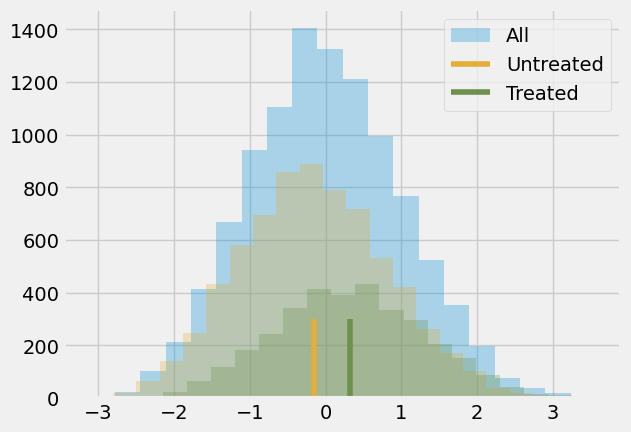

In [91]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend()
plt.show() ;

当然，我们仍认为这一结果存在偏误。处理组与未处理组之间的差异可能比这小，因为我们推测偏误为正。我们已经看到，更有抱负的人更愿意参加研讨会，因此即便未参与，他们可能也会取得更高成就。为控制这一偏误，可采用回归或匹配方法，但现在该学习一项新技术了。

## 倾向得分

倾向得分源于一个认识：无需直接控制混杂变量 X 即可实现条件独立性 $(Y_1, Y_0) \perp T | X$。实际上，控制一个平衡得分 $E[T|X]$ 就足够了。该平衡得分通常是处理的条件概率 $P(T|X)$，亦称倾向得分 $e(x)$。倾向得分使得不必对 X 整体进行条件限制就能实现潜在结果对处理的独立性，仅需对这一单一变量（即倾向得分）进行条件控制即可：

$
(Y_1, Y_0) \perp T | e(x)
$

关于这一点有一个正式的证明，但我们现在可以暂时忽略它，以更直观的方式来探讨这个问题。倾向得分是接受处理的条件概率，对吧？因此，我们可以将其视为某种将 X 转化为处理 T 的函数。倾向得分在变量 X 和处理 T 之间起到了桥梁的作用。如果我们在因果图中展示这一点，它看起来会是这样的。

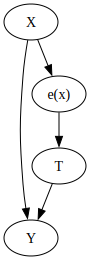

In [94]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

若已知 e(x)的值，仅凭 X 本身无法提供更多有助于预测 T 的信息。这意味着控制 e(x)的效果等同于直接控制 X。以我们的心态项目为例，处理组与对照组最初不具备可比性，因为更具雄心的人既更可能接受处理，也更容易在生活中取得更大成就。然而，若从处理组和对照组中各取一人，且这两人具有相同的处理接收概率时，他们便具有可比性。试想：若两人接受处理的概率完全相同，那么其中一人接受处理而另一人未接受的唯一原因纯属偶然。保持倾向得分不变的作用，就在于使数据看起来如同随机分配一般。

既然直观理解已建立，现在让我们审视数学证明。我们需要证明 $(Y_1, Y_0) \perp T | e(x)$ 等价于以下表述：

$
E[T|e(x), X] = E[T|e(x)] 
$

这实质上表明，在给定 $e(x)$ 的条件下，X 无法为 $T$ 提供任何额外信息。该证明过程颇为奇特：我们将通过将上述等式转化为一个不言自明的陈述来完成证明。首先观察等式左侧的 $E[T|e(x), X]$。

$
E[T|e(x), X] = E[T|X] = e(x)
$

我们利用 $e(x)$ 仅是 X 的函数这一事实，因此在已对 X 本身进行条件化后，再对其条件化不会提供额外信息。接着，我们运用倾向得分的定义 $E[T|X]$。

对于右侧，我们将使用迭代期望定律 $E[A] = E[E[A|B]]$。该定律表明，可以通过分解 B 后 A 的值来计算 A 的期望值，然后取其平均值。

$
E[T|e(x)] = E[E[T|e(x),X]|e(x)] = E[e(x)|e(x)] = e(x)
$

第一个等式源于迭代期望定律。第二个等式则来自我们在处理左侧时得出的结论。由于等式左右两边均等于 $e(x)$，故此等式显然成立。

## 倾向性加权

![img](./images/11/balance.png)

好的，我们得到了倾向得分。接下来呢？就像我说的，我们只需要以它为条件进行分析。例如，我们可以运行一个仅以倾向得分为条件的线性回归，而不是所有的 X 变量。现在，让我们看看一种仅使用倾向得分的技术。其核心思想是利用倾向得分来表达条件均值差异。

$
E[Y|X,T=1]-E[Y|X,T=0] = E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T))
$

我们还可以进一步简化这个表达式，但先以这种方式来看，它能帮助我们直观理解“倾向得分”到底在做什么。第一个项是在估计 $Y_1$，它是将所有接受处理的个体按其接受处理的概率的倒数进行加权。这个操作的效果是：那些接受处理但原本不太可能接受处理的个体被赋予更高的权重。

这很合理，对吧？如果一个人接受处理的概率很低，说明他更像是未接受处理的个体；然而他实际上却接受了处理——这就很有价值。**我们得到了一个“看起来像未处理人群”的受处理个体，因此要赋予他更高的权重**。通过这种方式，我们构造出一个“每个人都接受了处理”的人群，且这个人群的分布和原始人群相同。

同样地，第二个项处理的是未接受处理的个体，并且对那些“看起来像处理组”的个体赋予更高的权重。

这种估计方法被称为 **倾向得分逆概率加权法（IPTW, Inverse Probability of Treatment Weighting）**，因为它根据个体**实际接受的处理的概率的倒数**对每一个样本单位进行加权。

用图像展示，这就是加权所实现的效果。

![img](./images/11/iptw.png)

左上角的图表展示了原始数据。蓝点代表未经处理的样本，红点代表经过处理的样本。底部图表显示了倾向得分 $e(x)$。注意其值介于 0 到 1 之间，并随着 X 的增加而增长。最后，右上角的图表是加权后的数据。可以看到，位于左侧（倾向得分较低）的红点（处理组）具有更高的权重；同样，位于右侧的蓝点（对照组）也拥有更高的权重。

现在我们已经理解了直观概念，可以将上述表达式简化为

$$
\begin{align}
E[Y|X,T=1]-E[Y|X,T=0] &= E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T)) \\
&=E\bigg[\dfrac{YT}{e(x)}\bigg|X\bigg] - E\bigg[\dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[\dfrac{YT}{e(x)} - \dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y\dfrac{T(1-e(x)) - e(x)(1-T)}{e(x)(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg|X\bigg]
\end{align}
$$

若对 X 进行积分，该式即成为我们的倾向得分加权估计量。

$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$

注意，此估计量要求 $e(x)$ 和 $1-e(x)$ 必须大于零。换言之，这意味着每个人都需有一定概率接受处理和不接受处理。另一种表述是处理组与未处理组的分布需存在重叠，这正是因果推断中的**正值性假设**。这一假设在直观上也合乎逻辑——若处理组与未处理组无重叠，则表明两者差异极大，此时无法将一组的效应外推至另一组。虽然这种外推并非不可能（回归分析即采用此法），但其风险极高。这如同仅在男性群体中试验新药后，便假定女性群体会有同等疗效。


## 倾向得分估计

理想情况下，我们应掌握真实的倾向得分 $e(x)$。但实际上，处理分配机制未知，需用其估计值 $\hat{e}(x)$ 替代。常用方法是逻辑回归，但也可采用梯度提升等机器学习方法（尽管需额外步骤防止过拟合）。 

在此，我将坚持使用逻辑回归。这意味着我需要将数据集中的分类特征转换为虚拟变量。

```{dropdown} 查看 Stata 代码
```stata
* 1. Create dummy variables for categorical features
foreach var in ethnicity gender school_urbanicity {
    tab `var', gen(`var'_)
    label var `var'_1 "`var' category 1"
    * Drop reference category if needed (uncomment)
    * drop `var'_1
}

* 2. Keep only continuous variables and new dummies
keep achievement_score intervention ///
     school_mindset school_achievement school_ethnic_minority ///
     school_poverty school_size ethnicity_* gender_* school_urbanicity_* ///
	 schoolid frst_in_family schoolid success_expect

* 3. Display new dataset structure
describe
display "New dataset dimensions: " c(N) " observations, " c(k) " variables"

In [97]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


现在，让我们使用逻辑回归来估计倾向得分。

```{dropdown} 查看 Stata 代码
```stata
* 1. Run high-regularization logistic regression 
logit intervention school_mindset school_achievement school_ethnic_minority ///
                school_poverty school_size ethnicity_* gender_* school_urbanicity_*

* 2. Predict propensity scores
predict propensity_score, pr

* 3. Create new dataset with key variables
preserve
    keep schoolid intervention achievement_score propensity_score
    order schoolid intervention achievement_score propensity_score
    
    * Display first 5 observations
    list in 1/5, noobs clean
    
    * Save for analysis
    save propensity_scores, replace
restore

In [100]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315271
1,1,-0.449646,0.263482
2,1,0.769703,0.343781
3,1,-0.121763,0.343781
4,1,1.526147,0.367474


首先，我们可以确保倾向得分权重确实重构了一个所有人都接受处理的人群。通过生成权重 $1/e(x)$，它创建了一个所有人都接受处理的群体；而提供权重 $1/(1-e(x))$ 则创建了一个所有人都未接受处理的群体。

```{dropdown} 查看 Stata 代码
```stata
* 1. Calculate inverse probability weights
gen ipw = .
replace ipw = 1/propensity_score if intervention == 1
replace ipw = 1/(1-propensity_score) if intervention == 0

* 2. Calculate and display sample sizes
count
display "Original Sample Size: " r(N)

sum ipw if intervention == 1
display "Treated Population Sample Size: " r(sum)

sum ipw if intervention == 0
display "Untreated Population Sample Size: " r(sum)

In [103]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10387.611441322644
Untreated Population Sample Size 10391.5061043366


我们还可以利用倾向得分来寻找混杂因素的证据。如果某一人群分段的倾向得分高于另一分段，这意味着存在非随机因素导致处理分配。若该因素同时影响结果变量，则存在混杂。在本例中，我们发现自报更具雄心的学生参加成长心态研讨会的概率也更高。

```{dropdown} 查看 Stata 代码
```stata
* Set modern graph style
set scheme s2color
color_style tableau

* Create boxplot with enhanced formatting
graph box propensity_score, over(success_expect) ///
    title("Confounding Evidence", size(medium)) ///
    ytitle("Propensity Score", size(small)) ///
    box(1, color(blue%50)) ///
    box(2, color(orange%50)) ///
    box(3, color(green%50)) ///
    graphregion(color(white)) ///
    plotregion(color(white)) ///
    ylabel(0.2(0.05)0.5, grid gmin gmax) ///
    legend(off)

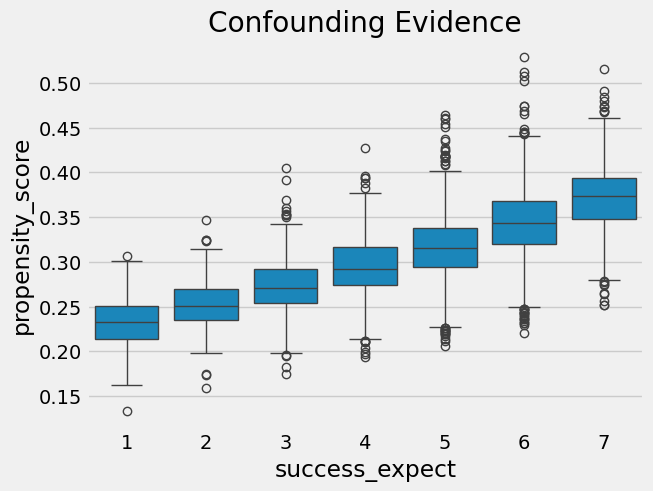

In [106]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")
plt.show();

我们还需检查处理组与未处理组之间是否存在重叠。为此，可以观察未处理组和处理组的倾向得分经验分布。从下图可见，无人具有零倾向得分，即使在倾向得分较低的区域也能同时找到处理与未处理的个体。这正是我们所说的处理组与未处理组良好平衡的状态。

```{dropdown} 查看 Stata 代码
```stata
*  Check propensity score distribution
twoway (histogram propensity_score if intervention==1, color(red%30)) ///
       (histogram propensity_score if intervention==0, color(blue%30)), ///
       legend(order(1 "Treated" 2 "Untreated")) ///
       title("Propensity Score Distribution") ///
       xtitle("Propensity Score") ///
       graphregion(color(white))

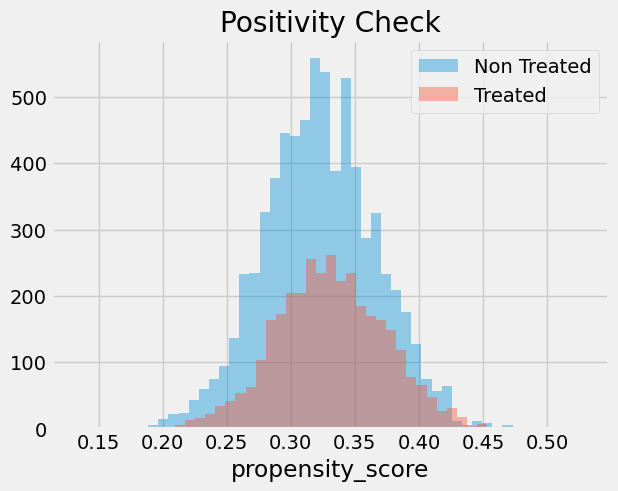

In [109]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend()
plt.show() ;

最终，我们可以利用倾向得分加权估计量来评估平均处理效应。

```{dropdown} 查看 Stata 代码
```stata
* 1. Calculate normalized IP weights
gen ipw1 = (intervention - propensity_score) / (propensity_score * (1 - propensity_score))

* 2. Calculate potential outcomes
sum achievement_score [aw=ipw1] if intervention == 1
scalar y1 = r(mean)

sum achievement_score [aw=ipw1] if intervention == 0
scalar y0 = r(mean)

* 3. Calculate ATE
scalar ate = y1 - y0

* 4. Display results with 95% CIs
display "Potential Outcomes and ATE:"
display "Y1: " %5.3f y1 " [95% CI: " %5.3f (y1 - invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) ", " %5.3f (y1 + invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) "]"
display "Y0: " %5.3f y0 " [95% CI: " %5.3f (y0 - invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) ", " %5.3f (y0 + invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) "]"
display "ATE: " %5.3f ate " [95% CI: " %5.3f (ate - invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) ", " %5.3f (ate + invttail(r(N)-1,0.025)*r(sd)/sqrt(r(N))) "]"

* 5. Recommended: Use teffects for proper inference
teffects ipw (achievement_score) (intervention, logit), ///
    osample(overlap) ///
    vce(robust)

In [112]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2598102832312275
Y0: -0.12903052834734596
ATE 0.38884081157857353


倾向得分加权法表明，就成就而言，我们应预期接受处理的个体比未接受处理的同伴高出 0.38 个标准差。同时可见，若无人接受处理，整体成就水平预计将比现状低 0.12 个标准差。同理，若让所有人参与研讨会，预期整体成就水平将提升 0.25 个标准差。这与简单对比处理组和未处理组得出的 0.47 平均处理效应估计值形成对比，证明存在的偏误确实为正，且通过控制变量 X 后，对成长心态影响的估计更为保守。

## 标准误差

![img](./images/11/bootstrap.png)

为计算逆概率加权估计量的标准误，可采用加权平均方差公式。

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

然而，仅当我们拥有真实的倾向得分时才能使用此方法。若采用其估计版本 $\hat{P}(x)$，则需考虑这一估计过程中的误差。最简便的做法是对整个流程进行自助法（bootstrap）处理，即通过有放回地从原始数据中抽样，并如上所述计算平均处理效应（ATE）。随后多次重复此过程，以获取 ATE 估计值的分布。

In [115]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

ATE 即为自助样本的均值。要获得置信区间，可考察自助分布的百分位数：对于 95%置信区间，采用 2.5%和 97.5%分位数。

In [119]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877390990017618
95% C.I.: (0.3544138347564195, 0.4197524732114395)


我们还可以直观展示自助样本的分布形态及其置信区间。

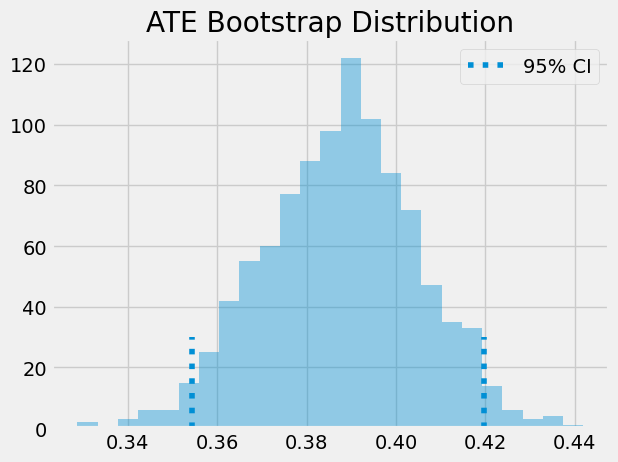

In [127]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend()
plt.show();

## 倾向得分法的常见问题

作为一名数据科学家，我深知利用机器学习工具包的全部力量来尽可能精确地估计倾向得分是多么诱人。你可能会迅速沉迷于 AUC 优化、交叉验证和贝叶斯超参数调优之中。我并不是说你不该这么做。事实上，关于倾向得分与机器学习的所有理论都非常新近，我们仍有许多未知领域。但首先理解一些基本概念是值得的。

首要一点是，倾向得分的预测质量并不等同于其平衡特性。来自机器学习领域的学者在熟悉因果推断时，最富挑战性的方面之一便是放弃将一切视为预测问题的习惯。实际上，最大化倾向得分的预测能力甚至可能损害因果推断的目标。 **倾向得分无需非常精确地预测处理分配，它只需涵盖所有混杂变量。** 若纳入那些虽能有效预测处理分配但与结果无关的变量，反而会增加倾向得分估计量的方差。这与线性回归中纳入与处理相关但与结果无关变量时所面临的问题类似。

![img](./images/11/ml-trap.png)

为了理解这一点，请考虑以下示例（改编自 Hernán 的著作）。假设有两所学校，其中一所对 99%的学生实施了成长心态研讨会，另一所仅对 1%的学生实施。进一步假设学校本身对处理效应无直接影响（除非通过处理本身），因此无需对其进行控制。若将学校变量加入倾向得分模型，该变量将具有极高的预测力。然而，偶然情况下，我们可能获得一个样本，其中学校 A 的所有学生均接受了处理，导致该校倾向得分为 1，进而引发方差无限大的问题。此虽为极端案例，但我们将通过模拟数据展示其运作机制。

```{dropdown} 查看 Stata 代码
```stata
clear all
set seed 42  // Set random seed for reproducibility (matches Python's np.random.seed(42))

// Create data for School A
set obs 400  // Create 400 observations
gen school = 0  // School identifier (0 for School A)
gen intercept = 1  // Constant/intercept term
gen T = rbinomial(1, 0.99)  // Generate treatment variable (99% probability of 1)
tempfile school_a  // Create temporary file to store School A data
save `school_a'  // Save School A data

// Create data for School B
clear  // Clear memory
set obs 400  // Create 400 observations
gen school = 1  // School identifier (1 for School B)
gen intercept = 1  // Constant/intercept term
gen T = rbinomial(1, 0.01)  // Generate treatment variable (1% probability of 1)
tempfile school_b  // Create temporary file to store School B data
save `school_b'  // Save School B data

// Combine datasets (equivalent to pd.concat in Python)
use `school_a', clear  // Load School A data
append using `school_b'  // Append School B data

// Generate outcome variable y (equivalent to .assign() in Python)
gen y = rnormal(1 + 0.1 * T)  // y ~ N(1 + 0.1*T, 1)

// Display first 5 observations (equivalent to .head() in Python)
list in 1/5	

In [130]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


完成数据模拟后，我们使用倾向得分算法进行了两次自助法（bootstrap）分析。第一次将学校作为特征纳入倾向得分模型，第二次则未将学校变量纳入模型。

```{dropdown} 查看 Stata 代码
```stata
// Define program to estimate ATE
capture program drop run_ps
program define run_ps, rclass
    syntax varlist, TREATment(varname) OUTcome(varname)
    
	// Remove existing ps variable if it exists
    capture drop ps
    capture drop weight
	
    // Logistic regression for propensity score
    logit `treatment' `varlist'
    predict ps, pr  // Get propensity scores
    
    // IPW estimation (inverse probability weighting)
    tempvar weight
    gen `weight' = `treatment'/ps + (1-`treatment')/(1-ps)
    
    // Weighted regression for ATE
    reg `outcome' `treatment' [pw=`weight']
    
    // Return coefficient on treatment
    return scalar ate = _b[`treatment']
end

// Initialize matrices to store results (equivalent to np.array)
matrix ate_w_f = J(500, 1, .)  // With school fixed effect
matrix ate_wo_f = J(500, 1, .)  // Without school fixed effect

// Bootstrap loop (500 replications)
forvalues i = 1/500 {
    preserve  // Preserve original data
    
    // Resample with replacement (equivalent to sample(frac=1, replace=True))
    bsample
    
    // Run estimation with school fixed effect
    run_ps school, treatment(T) outcome(y)
    matrix ate_w_f[`i', 1] = r(ate)
    
    // Run estimation with only intercept
    run_ps intercept, treatment(T) outcome(y)
    matrix ate_wo_f[`i', 1] = r(ate)
    
    restore  // Restore original data
}

// Convert matrices to Stata variables for analysis
clear
svmat ate_w_f, names(ate_with_fixed)
svmat ate_wo_f, names(ate_without_fixed)

// Summarize results
summarize ate_with_fixed ate_without_fixed

// Create kernel density plots with histograms
twoway ///
    (histogram ate_with_fixed, color(blue%30) bin(30) legend(label(1 "PS W School"))) ///
    (histogram ate_without_fixed, color(red%30) bin(30) legend(label(2 "PS W/O School"))) ///
    (kdensity ate_with_fixed, lcolor(blue) lwidth(medthick)) ///
    (kdensity ate_without_fixed, lcolor(red) lwidth(medthick)), ///
    legend(order(1 2) position(6) rows(1)) ///
    title("Distribution of ATE Estimates") ///
    xtitle("ATE Estimate") ytitle("Density") ///
    graphregion(color(white)) plotregion(color(white))

In [133]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

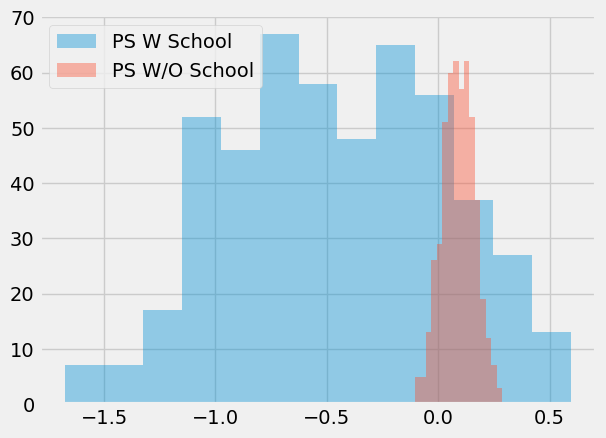

In [139]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend()
plt.show() ;

如你所见，加入学校特征的倾向得分估计器方差极大，而未加入该特征的模型则表现更为稳定。此外，由于学校并非混淆变量，未包含它的模型也不存在偏误。正如我所说，这并非单纯预测处理效应的问题，关键在于构建预测模型时必须控制混杂因素，而非仅着眼于预测处理本身。

这引出了倾向得分方法中常见的另一个问题。在我们的案例中，数据最终呈现高度平衡状态，但情况并非总是如此。某些情况下，接受处理者的处理概率远高于未处理者，且倾向得分分布的重叠区域非常有限。

```{dropdown} 查看 Stata 代码
```stata
// Set seed for reproducibility
set seed 42

// Generate Beta-distributed data (500 obs each)
set obs 500
gen non_treated = rbeta(4,1)  // Beta(4,1) distribution
gen treated = rbeta(1,3)      // Beta(1,3) distribution

// Create histogram plot for positivity check
twoway ///
    (histogram non_treated, color(blue%30) bin(30) legend(label(1 "Treated"))) ///
    (histogram treated, color(red%30) bin(30) legend(label(2 "Non-Treated"))), ///
    title("Positivity Check") ///
    xtitle("Propensity Score") ytitle("Frequency") ///
    legend(order(1 2) position(6) rows(1)) ///
    graphregion(color(white)) plotregion(color(white))	   

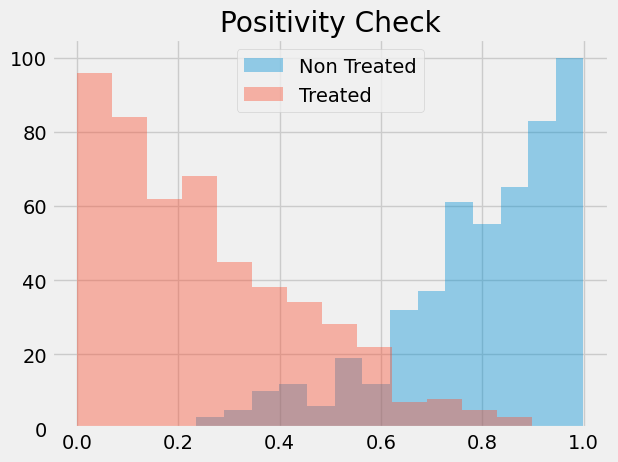

In [146]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend()
plt.show() ;

若出现这种情况，意味着正向效应并不十分显著。假设某处理个体的倾向得分为 0.9，而未处理个体的最大倾向得分为 0.7，我们将无法找到任何未处理个体与这位 0.9 分的个体进行对比。这种匹配失衡可能引发偏误，因为我们必须将处理效应外推至未知区域。不仅如此，具有极高或极低倾向得分的实体权重过大，这会增加方差。根据经验法则，当任何权重超过 20 时（例如未处理个体倾向得分达 0.95 或处理个体倾向得分低至 0.05 时），就会面临问题。

另一种方法是将权重限制在最大值为 20。这样做会降低方差，但实际上会增加偏误。坦白说，尽管这是减少方差的常见做法，我并不十分赞同。你无法确定通过截断引入的偏误是否过大。此外，若分布间无重叠，数据可能本就不足以得出因果结论。为了更深入理解这一点，我们可以考察一种结合倾向得分与匹配的技术。

## 倾向得分匹配

如前所述，在拥有倾向得分的情况下，无需直接控制变量 X，仅控制倾向得分即可。因此，可将倾向得分视为对特征空间的一种降维操作——它将 X 中的所有特征压缩至单一的处理分配维度。基于此，我们可将倾向得分作为其他模型（例如回归模型）的输入特征。

```{dropdown} 查看 Stata 代码
```stata
reg achievement_score intervention propensity_score,vce(robust)	   
	   
* Recommended: Use teffects for proper inference
teffects ipw (achievement_score) (intervention, logit), ///
    osample(overlap) ///
    vce(robust)	

In [149]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0819,0.066,-46.988,0.000,-3.211,-2.953
intervention,0.3931,0.019,20.975,0.000,0.356,0.430
propensity_score,9.0700,0.200,45.244,0.000,8.677,9.463


若我们控制了倾向得分，现估计出的平均处理效应（ATE）为 0.39，低于此前未控制倾向得分的回归模型所得结果 0.47。此外，我们还可基于倾向得分进行匹配。此次，无需寻找所有 X 特征均相似的匹配对象，仅需确保其倾向得分相同即可。

这是对匹配估计量的重大改进，因其解决了维度灾难问题。再者，若某特征对处理分配影响甚微，倾向得分模型会识别这一点，并在拟合处理机制时降低其权重。相比之下，基于特征的匹配仍会试图在个体间这一无关紧要的特征上寻找相似性。

In [152]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.383      0.025     15.252      0.000      0.334      0.432
           ATC      0.371      0.028     13.434      0.000      0.317      0.425
           ATT      0.407      0.027     15.341      0.000      0.355      0.459



如我们所见，此处亦获得 0.38 的平均处理效应（ATE），这与先前采用倾向得分加权法所得结果更为吻合。通过倾向得分匹配，我们还能直观理解为何处理组与对照组间倾向得分重叠区域过小会带来风险。一旦出现这种情况，倾向得分差异导致的匹配偏误将显著增大，正如我们在匹配章节中已探讨的那样，这会引入估计偏误。

最后需要特别提醒的是，上述标准误计算存在错误，因其未考虑倾向得分估计过程中的不确定性。遗憾的是，[自助法（bootstrap）并不适用于匹配场景](https://economics.mit.edu/sites/default/files/publications/ON%20THE%20FAILURE%20OF%20THE%20BOOTSTRAP%20FOR.pdf)。此外，相关理论提出时间较近，目前尚无 Python 库能提供含正确标准误的倾向得分方法实现。正因如此，Python 生态中鲜见倾向得分匹配的应用案例。

## 核心要点

在本节中，我们学到了“接受处理的概率”被称为倾向得分（propensity score），并且它可以作为一种平衡得分（balancing score）来使用。
这意味着，如果我们已经得到了倾向得分，就不需要再直接控制所有混杂变量了——只需控制倾向得分本身，就足以识别因果效应。我们还看到，倾向得分在某种程度上起到了对混杂变量空间进行降维**的作用。

正是由于这些性质，我们推导出了一个基于加权的因果推断估计量（如 IPTW）。不仅如此，我们还看到倾向得分可以与其他方法结合使用，以控制混杂偏误。

接着，我们讨论了一些倾向得分和因果推断中常见的问题。第一个问题是：当我们过于关注拟合处理机制时，可能会出错。我们发现，有一个非常违反直觉（因此也容易出错）的现象是：提升处理机制的预测性能，并不意味着更好的因果效应估计，反而可能会增加估计的方差。

最后，我们还探讨了当处理组与对照组之间的倾向得分分布没有良好重叠时，可能会出现的外推问题。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。